In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load constants
FREQ_START = 1419.84
FREQ_STEP = 0.00781250
RECORDINGMODE = 4
NBINS = 148
tsys = 0

In [3]:
# set data indices
CMD = 0
DATA_START = 12

# load raw data from rad file. 
# returns calibration tsys and a matrix where each row has form:
# CMD, TIMESTAMP, AZ, EL, AZOFF, ELOFF, GLON, GLAT, FREQ_START, FREQ_STEP, RECORDINGMODE, # OF BINS, *DATA (in K)
def load_data(file):
    with open(file) as f:
        data = []
        lines = f.readlines()
        for i in range(len(lines)):
            if 'cmd' in lines[i]: # comments with 'cmd' indicate execution of a line from the .cmd file
                data.append([lines[i]] + lines[i+1].split()[:-2]) # ignore vlsr data
            elif 'tsys' in lines[i]:
                bg = lines[i+2].split()[:-2]
                tsys = int(lines[i].split()[2]) # hardcode location of tsys value
        return np.array(bg), np.array(data)
    
# remove background t from data
def remove_background(sweep, tsys):
    remove_background = sweep - tsys
    drop_negatives = np.where(remove_background > 0, remove_background, 0)
    return drop_negatives

# Sun Sweep Analysis

### TODO:
* add a parameter for horizontal shift
* decide what to do with the vertical shift (theoretically we should subtract tsys from everything, but this makes some values negative
* all sweeps except 171110-01 are broken
* find the aperture of the SRT

In [4]:
# convert antenna temperature to brightness temperature
def antennaT_to_brightnessT(sweep):
    ANTENNA_ANG_DIAM = 7
    SOURCE_ANG_DIAM = .5
    POLARIZATION_FACTOR = 2 # antenna only measures 1 polarization direction
    return sweep * (ANTENNA_ANG_DIAM / SOURCE_ANG_DIAM)**2 * POLARIZATION_FACTOR

# process sunsweep data
# input: full rows from load_data
# output: avg brightness temperature for each angle with error
def process_sunsweep(raw_data, bg):
    # TODO: DATA_START should be calcuated from raw_data rather than stored globally
    rm_metadata = np.asfarray(raw_data[:, DATA_START:], float)
    avg_antennaT = np.mean(rm_metadata, axis=1)
    rm_bg_antennaT = remove_background(avg_antennaT, tsys)
    avg_brightnessT = antennaT_to_brightnessT(rm_bg_antennaT)

    err_antennaT = np.sqrt(avg_antennaT)
    err_brightnessT = antennaT_to_brightnessT(err_antennaT)
    
    utils.init_plot()
    utils.plot_data(range(len(avg_brightnessT)), avg_brightnessT, err_brightnessT)
    plt.show()
    
    return avg_brightnessT, err_brightnessT

In [45]:
# define diffraction model
# TODO: note that the aperture is left floating. we should try to find the actual value for this.
import scipy.special
def circular_diffraction(theta, I, a, b):
    k = 29.7695032399
    return np.where(theta == 0, b+I, b+I * ( (2 * scipy.special.j1(k * a * np.sin(theta))) / (k * a * np.sin(theta)) )**2)

In [336]:
# load data to tsys, raw
file = '21cm/sunsweeps/171110-01.rad'
bg, raw = load_data(file)

In [337]:
# selectTab suspended
# rows to analyze
# TODO: make more robust selection mechanism (perhaps by adding comments to the cmd file?)
azsweep = np.array([raw[i] for i in range(5, 36)])
elsweep = np.array([raw[i] for i in range(36, 67)])

[ 0.82646764  0.83114151  0.82991844  0.82771236  0.82436032  0.82796052
  0.82852276  0.8401396   0.86749231  0.90103321  0.93898257  0.9903617
  1.05016391  1.10953888  1.106397    1.1169248   1.10923023  1.07978385
  1.03273662  0.97202938  0.92842116  0.88370526  0.85199997  0.83426111
  0.82975339  0.83406408  0.82807355  0.82081664  0.82265837  0.82163662
  0.81542046]
[ 1.64865694  1.65333081  1.65210774  1.64990166  1.64654963  1.65014983
  1.65071206  1.66232891  1.68968162  1.72322252  1.76117188  1.812551
  1.87235321  1.93172818  1.9285863   1.9391141   1.93141954  1.90197315
  1.85492592  1.79421869  1.75061046  1.70589457  1.67418927  1.65645041
  1.65194269  1.65625339  1.65026286  1.64300594  1.64484768  1.64382593
  1.63760976]


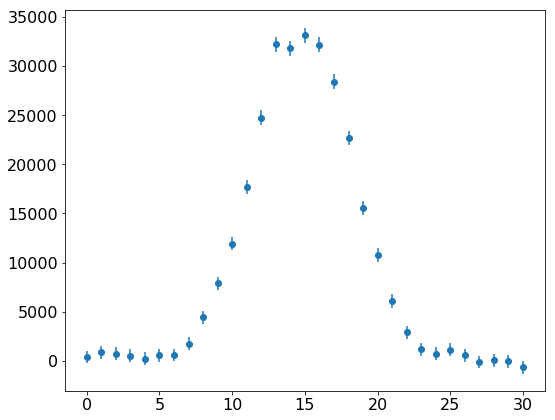

[  3.36628806e+04   7.61217017e-01   1.14713135e+02] [  3.84031766e+02   9.21327667e-03   1.68872271e+02] 1.90591761305


In [338]:
x = np.array([i*2*3.14/360 for i in range(-15, 16, 1)])

bg = np.asfarray(bg[DATA_START-1:], float)

raw_data = azsweep
rm_metadata = np.asfarray(raw_data[:, DATA_START:], float)
avg_antennaT = np.mean(rm_metadata, axis=1)
#rm_bg_antennaT = remove_background(avg_antennaT, tsys)
rm_bg_antennaT = avg_antennaT - np.mean(bg)
avg_brightnessT = antennaT_to_brightnessT(rm_bg_antennaT)

err_antennaT = np.sqrt(np.sum(rm_metadata, axis=1))/148
err_bg = np.sqrt(np.sum(bg))/148
err_brightnessT = antennaT_to_brightnessT(err_antennaT + err_bg)

print(err_antennaT)
print(err_antennaT + err_bg)

utils.init_plot()
utils.plot_data(range(len(avg_brightnessT)), avg_brightnessT, err_brightnessT)
plt.show()

y, ey = avg_brightnessT, err_brightnessT

np.seterr(divide='ignore', invalid='ignore')
popt, perr, chisq = utils.fit_model(x, y, ey, (30000, 1, 0), circular_diffraction)
print(popt, perr, chisq/(len(avg_brightnessT)-3))

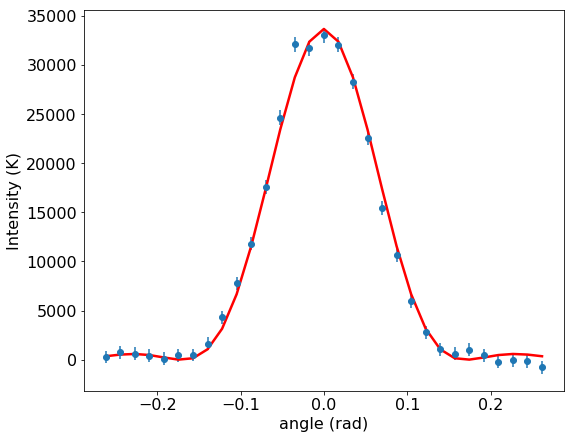

In [339]:
utils.init_plot()
utils.plot_data(x, y-popt[2], ey)
utils.plot_model(x, circular_diffraction, (popt[0], popt[1], 0), 'r', '')
plt.xlabel('angle (rad)')
plt.ylabel('Intensity (K)')
#plt.savefig('21cm/sunsweep.png')
plt.show()

# Galactic Plane Analysis

In [340]:
file = '21cm/galsweeps/171112-01.rad'
bg, raw = load_data(file)
sweep = np.array([row for row in raw if 'galactic' in row[0] and len(row) == 160])
#print(sweep)

bg = np.asfarray(bg[DATA_START-1:], float)
#plt.plot(bg)

In [341]:
# define spectral redshift models
def gaussian(x, a, m, s):
    return a * np.exp(-(x-m)**2/(2*s**2))

def spectra1(x, a, m, s, h):
    return gaussian(x, a, m, s) + h

def spectra2(x, a1, m1, s1, a2, m2, s2, h):
    return gaussian(x, a1, m1, s1) + gaussian(x, a2, m2, s2) + h

In [342]:
bins = 37

x = np.arange(FREQ_START, FREQ_START+FREQ_STEP*NBINS, FREQ_STEP*(NBINS/bins))

rm_metadata = np.asfarray(sweep[:, DATA_START:], float)
rebin = [np.array([np.sum(row[i:i+int(NBINS/bins)]) for i in range(0, len(row), int(NBINS/bins))]) for row in rm_metadata]
rebin_bg = np.array([np.sum(bg[i:i+int(NBINS/bins)]) for i in range(0, len(bg), int(NBINS/bins))])
rm_bg = [row - rebin_bg for row in rebin]
y = np.array(rm_bg)

ey_data = np.sqrt(rebin)/40
ey_bg = np.sqrt(rebin_bg)/40
ey = [ey_data_row + ey_bg for ey_data_row in ey_data]

# drop edges
x = x[2:-2]
y = [row[2:-2] for row in y]
ey = [row[2:-2] for row in ey]
#utils.init_plot()
#utils.plot_data(x, y[7], ey[7])
#plt.plot(x, rm_bg[7])
#plt.show()

In [345]:
heights = (39, 39, 40, 37, 29, 12, 10, 10, 10, 0, 0, 0)
means = (1420.4, 1420.4, 1420.4, 1420.4, 1420.4, 1420.2, 1420.3, 1420.4, 1420.4, 1420.2, 1420.2, 1420.2)
zero_freq = []
err = []
chisqs = []
for i in range(len(y)):
#for i in range(0, 1):
    popt1, perr1, chisq1 = utils.fit_model(x, y[i], ey[i], (1, means[i], 1, heights[i]), spectra1)
    zero_freq.append(popt1[1]-2*abs(popt1[2]))
    err.append(perr1[1]-2*perr1[2])
    chisqs.append(chisq1/(bins-4))
    
    print(sweep[i][0])
    print(popt1[1]-2*abs(popt1[2]))
    print(perr1[1]+2*perr1[2])
    print(chisq1/(bins-4))
    #utils.init_plot()
    #utils.plot_data(x, y[i], ey[i])
    #utils.plot_model(x, spectra1, popt1, 'r', '')
    #plt.xlabel('Frequency (Hz)')
    #plt.ylabel('Intensity (K)')
    #plt.savefig('21cm/0.png')
    #plt.show()
    
#zero_freq[4] = 1420.7
zero_freq[6] = 1420.05
zero_freq[7] = 1420.05
err[6] = .02
err[7] = .02
print(zero_freq)
print(err)
print(chisqs)

* hmfest/scripts/galsweep20.cmd: line 6 : galactic 0 0

1420.1795082
0.0104829585244
11.6723514838
* hmfest/scripts/galsweep20.cmd: line 7 : galactic 5 0

1420.19326702
0.0124746826608
20.9569496671
* hmfest/scripts/galsweep20.cmd: line 8 : galactic 10 0

1420.17757217
0.0130764591553
27.3505934593
* hmfest/scripts/galsweep20.cmd: line 9 : galactic 15 0

1420.12237395
0.0166493606939
16.8344696736
* hmfest/scripts/galsweep20.cmd: line 12 : galactic 30 0

1420.55765733
0.124139743232
15.5504533873
* hmfest/scripts/galsweep20.cmd: line 13 : galactic 35 0

1420.16975882
0.0119553648138
15.1532770134
* hmfest/scripts/galsweep20.cmd: line 15 : galactic 45 0

1376.47894087
nan
14.8089287726
* hmfest/scripts/galsweep20.cmd: line 16 : galactic 50 0

1376.17727627
6849.04159217
14.4532552423
* hmfest/scripts/galsweep20.cmd: line 17 : galactic 55 0

1420.13899976
0.0127557616605
15.3181518855
* hmfest/scripts/galsweep20.cmd: line 19 : galactic 65 0

1420.00190685
0.0322153983882
27.533823212
* h

[-46.56965578 -43.66368216 -46.97856079 -58.63687274  33.29850685
 -48.62880459 -73.92283864 -73.92283864 -55.12536699 -84.08050187
 -74.77162774 -30.31030078]
[ 0.          0.08722222  0.17444444  0.26166667  0.52333333  0.61055556
  0.785       0.87222222  0.95944444  1.13388889  1.22111111  1.30833333]
[8.5700272779373847, 8.7134066275359885, 9.1259178548527302, 9.7621202904000555, 12.450318170678187, 13.44557909542845, 15.381683329564165, 16.27687749828992, 17.10022263105623, 18.480680564138581, 19.017702321560385, 19.442649223556611]


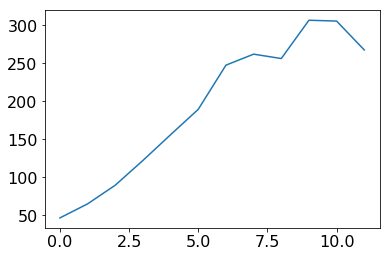

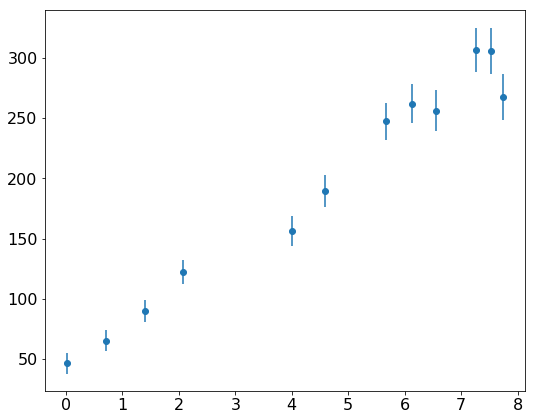

In [346]:
zero_v = 3e5 * (np.array(zero_freq)/1420.4 - 1)
print(zero_v)

deg = np.array([int(s.split()[-2]) for s in sweep[:,0]])
lons = 2*3.14*deg/360 # in rad
errlons = 12*[2*3.14*(2)/360]
r = 8*np.sin(lons)+.01 # so it doesn't try to fit with a 0
print(lons)

to_v_abs = 2*3.14*2.46854207e17/6.31139e15*np.sin(lons) + np.abs(zero_v)
plt.plot(to_v_abs)

import math
for i in range(len(err)):
    err[i] = (9*err[i]**2 + 20**2*math.sin(lons[i])**2 + errlons[i]**2*(2*3.14*2.4685e17/6.311e15*math.cos(lons[i]))**2)**.5

print(err)
utils.init_plot()
utils.plot_data(r, to_v_abs, err)

In [326]:
# define rotation curve models
def kepler(r, a):
    return a*r**-.5

def bulgedisk(r, a, b, c):
    return np.where(r < a, b*r, 3*a+c*r**-.5)

/home/evan/.env/jlab/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


186.763131905
8.99187743352


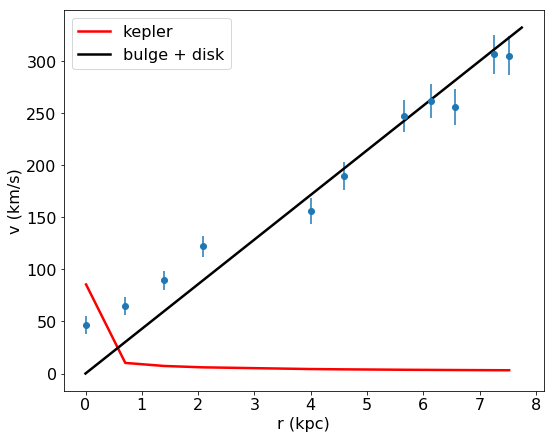

In [348]:
popt, perr, chisq = utils.fit_model(r[:-1], to_v_abs[:-1],err[:-1], (1), kepler)
popt2, perr2, chisq2 = utils.fit_model(r[:-1], to_v_abs[:-1],err[:-1], (2, 1, 1), bulgedisk)

utils.init_plot()
utils.plot_data(r[:-1], to_v_abs[:-1],err[:-1])
utils.plot_model(r[:-1], kepler, popt, 'r', 'kepler')
print(chisq/10)
print(chisq2/8)
utils.plot_model(np.arange(0, 8, .25), bulgedisk, popt2, 'k', 'bulge + disk')
plt.legend()
plt.xlabel('r (kpc)')
plt.ylabel('v (km/s)')
#plt.savefig('21cm/rotationcurve.png')
plt.show()